In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e10/sample_submission.csv
/kaggle/input/playground-series-s5e10/train.csv
/kaggle/input/playground-series-s5e10/test.csv


In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn import metrics
from xgboost import plot_importance

In [3]:
metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

In [4]:
df=pd.read_csv("/kaggle/input/playground-series-s5e10/train.csv")
X_test=pd.read_csv('/kaggle/input/playground-series-s5e10/test.csv')
X=df.copy()

In [5]:
# turning 'objects' dtype to 'category' to make suitable for XGBoost
for col in X.columns:
    if X[col].dtype == 'object':
         X[col] = X[col].astype('category')

In [6]:
X['id'].dtype
y=X.pop('accident_risk')

# I decided to create few "helper functions" to register progress 

One just make out-of-box XGBoost model \
Second - write down the result to compare 


In [7]:
# creating Score table to compare scores, the name column - just to prevent some trubles with adding names with .iloc[-1,-1]
Scoresy=pd.DataFrame()
Scoresy['experiment_name'] = pd.Series()

In [8]:
## Defining two helper functions: first for scoring, and second for saving score to table
def get_scored(X,y):    
    model = XGBRegressor(enable_categorical=True)
    score = cross_val_score(model,X,y,cv=5,scoring='neg_mean_squared_error')
    print(f'RMSE on 5 folds {np.sqrt(-1*score.mean())}')
    return score

def save_score(score, Scoresy, name):
    Scoresy = pd.concat([Scoresy, pd.DataFrame(np.sqrt(-1*score)).T],ignore_index=True)
    Scoresy['mean']= Scoresy[[0,1,2,3,4]].mean(axis=1)
    Scoresy['std'] = Scoresy[[0,1,2,3,4]].std(axis=1)
    Scoresy.iloc[-1, 0]=name
    return Scoresy

## Just Baseline
(maybe its better define some params, - not sure)

In [9]:
# Let's create first Baseline!
Score = get_scored(X,y)
Scoresy = save_score(Score, Scoresy, 'Baseline')

RMSE on 5 folds 0.05663654556876934


In [69]:
Scoresy

,experiment_name,0,1,2,3,4,mean,std
0,Baseline,0.057434,0.055794,0.056358,0.05633,0.05725,0.056633,0.000688


## Building Intuition

In [12]:
# relation betweeen cats and target
# curvature - clustering


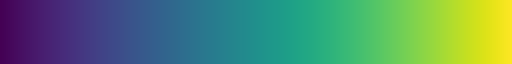

In [14]:
sns.color_palette("viridis", as_cmap=True)

In [11]:
X.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1


In [12]:
df_frac = df.sample(n =20000)

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


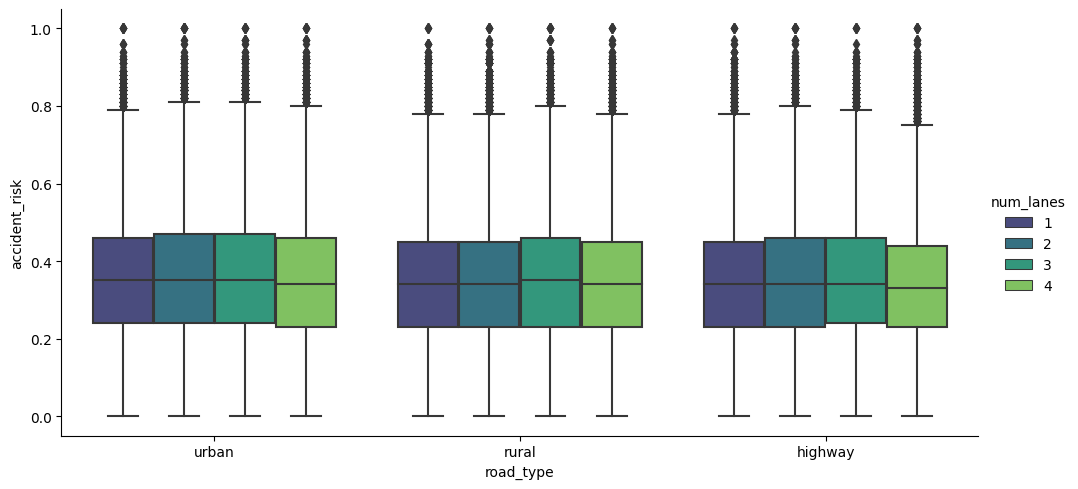

In [13]:
sns.catplot(data = df, x='road_type', y='accident_risk', kind="box",height=5, aspect=2, hue='num_lanes',palette="viridis")

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='accident_risk', ylabel='curvature'>

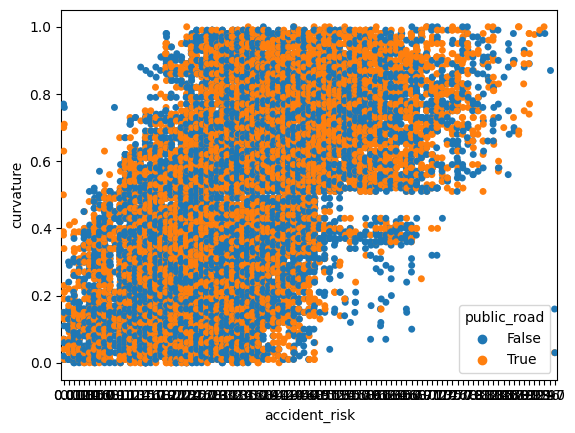

In [14]:
sns.stripplot(data=df_frac, x='accident_risk' ,y='curvature', hue= 'public_road')

<Axes: xlabel='weather', ylabel='accident_risk'>

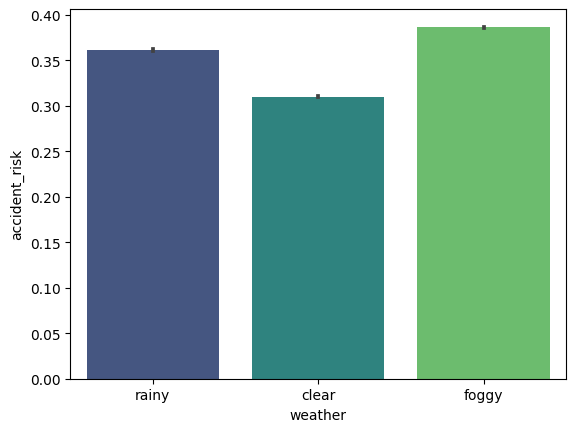

In [15]:
sns.barplot(data = df, y='accident_risk', x='weather', palette="viridis")

<Axes: xlabel='time_of_day', ylabel='accident_risk'>

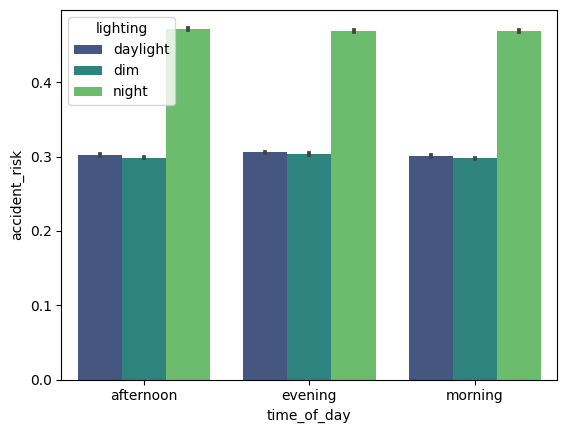

In [56]:
sns.barplot(data = df, y='accident_risk', x='time_of_day',hue='lighting', palette="viridis")

### thats strnge, but its fine to have 'night' and 'afternoon' in day time, maybe some data are, kind off, gathered from polar reageon with half-year night . LOL maybe, maybe 

In [10]:
X[X['time_of_day']=='afternoon']

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1
9,9,urban,4,0.38,45,dim,clear,True,True,afternoon,True,True,2
10,10,highway,1,0.45,45,dim,clear,False,False,afternoon,True,False,2
15,15,urban,1,0.52,60,daylight,clear,False,True,afternoon,True,False,1
18,18,rural,3,0.72,60,night,foggy,True,True,afternoon,True,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
517748,517748,rural,2,0.53,70,dim,foggy,True,True,afternoon,True,True,2
517749,517749,highway,4,0.10,70,daylight,foggy,True,True,afternoon,False,False,2
517751,517751,urban,4,0.62,25,daylight,foggy,False,False,afternoon,False,True,0
517752,517752,highway,3,0.63,25,night,clear,True,False,afternoon,True,True,3


## Feature engineering

I found that 'id' column is kind of toxic one

In [10]:
X.pop('id')

0              0
1              1
2              2
3              3
4              4
           ...  
517749    517749
517750    517750
517751    517751
517752    517752
517753    517753
Name: id, Length: 517754, dtype: int64

In [11]:
Score = get_scored(X,y)
Scoresy = save_score(Score, Scoresy, 'id_drop')

RMSE on 5 folds 0.056161994287263574


In [12]:
X['num_lanes_cat']=X['num_lanes']
X['num_lanes_cat']=X['num_lanes_cat'].astype('category')

In [13]:
Score = get_scored(X,y)
Scoresy = save_score(Score, Scoresy, 'num_lanes_to_category_copy')
Scoresy.head()

RMSE on 5 folds 0.05616428457315217


,experiment_name,0,1,2,3,4,mean,std
0,Baseline,0.057434,0.055794,0.056358,0.056330,0.057250,0.056633,0.000688
1,id_drop,0.056413,0.055778,0.056384,0.056270,0.055961,0.056161,0.000279
2,num_lanes_to_category_copy,0.056380,0.055809,0.056369,0.056288,0.055974,0.056164,0.000258


In [14]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   id                      517754 non-null  int64   
 1   road_type               517754 non-null  category
 2   num_lanes               517754 non-null  int64   
 3   curvature               517754 non-null  float64 
 4   speed_limit             517754 non-null  int64   
 5   lighting                517754 non-null  category
 6   weather                 517754 non-null  category
 7   road_signs_present      517754 non-null  bool    
 8   public_road             517754 non-null  bool    
 9   time_of_day             517754 non-null  category
 10  holiday                 517754 non-null  bool    
 11  school_season           517754 non-null  bool    
 12  num_reported_accidents  517754 non-null  int64   
 13  num_lanes_cat           517754 non-null  category
dtypes: b

In [26]:
model = XGBRegressor(enable_categorical=True)
model.fit(X,y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

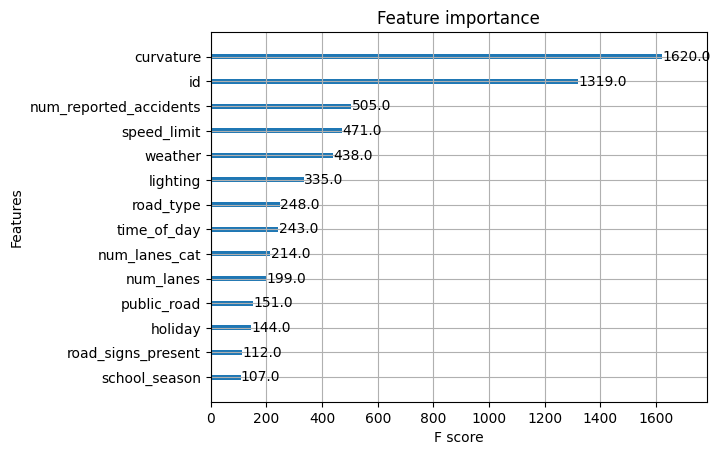

In [27]:
plot_importance(model)

In [14]:
X['weather'] = X['weather'].map({'clear': 0, 'foggy': 1, 'rainy':2})

In [15]:
X['weather'] = X['weather'].astype(int)

In [16]:
Score = get_scored(X,y)
Scoresy = save_score(Score, Scoresy, 'weather_encoded_manual_int')
Scoresy.head()

RMSE on 5 folds 0.056161835912086344


,experiment_name,0,1,2,3,4,mean,std
0,Baseline,0.057434,0.055794,0.056358,0.056330,0.057250,0.056633,0.000688
1,id_drop,0.056413,0.055778,0.056384,0.056270,0.055961,0.056161,0.000279
2,num_lanes_to_category_copy,0.056380,0.055809,0.056369,0.056288,0.055974,0.056164,0.000258
3,weather_encoded_manual_int,0.056412,0.055784,0.056361,0.056268,0.055982,0.056161,0.000269


In [17]:
X['lighting']=X['lighting'].map({'night':0, 'dim':1, 'daylight' : 2})


In [18]:
X['lighting'] = X['lighting'].astype(int)

In [19]:
Score = get_scored(X,y)
Scoresy = save_score(Score, Scoresy, 'lighting_encoded_manual')
Scoresy.head()

RMSE on 5 folds 0.05616494529806578


,experiment_name,0,1,2,3,4,mean,std
0,Baseline,0.057434,0.055794,0.056358,0.056330,0.057250,0.056633,0.000688
1,id_drop,0.056413,0.055778,0.056384,0.056270,0.055961,0.056161,0.000279
2,num_lanes_to_category_copy,0.056380,0.055809,0.056369,0.056288,0.055974,0.056164,0.000258
3,weather_encoded_manual_int,0.056412,0.055784,0.056361,0.056268,0.055982,0.056161,0.000269
4,lighting_encoded_manual,0.056442,0.055795,0.056348,0.056253,0.055984,0.056164,0.000268


In [20]:
bool_cats=['road_signs_present','public_road', 'holiday', 'school_season']

In [21]:
X[bool_cats] = X[bool_cats] .astype(int)

In [22]:
Score = get_scored(X,y)
Scoresy = save_score(Score, Scoresy, 'bool_cats_to_int_exp')
Scoresy.head(10)

RMSE on 5 folds 0.05616494529806578


,experiment_name,0,1,2,3,4,mean,std
0,Baseline,0.057434,0.055794,0.056358,0.056330,0.057250,0.056633,0.000688
1,id_drop,0.056413,0.055778,0.056384,0.056270,0.055961,0.056161,0.000279
2,num_lanes_to_category_copy,0.056380,0.055809,0.056369,0.056288,0.055974,0.056164,0.000258
3,weather_encoded_manual_int,0.056412,0.055784,0.056361,0.056268,0.055982,0.056161,0.000269
4,lighting_encoded_manual,0.056442,0.055795,0.056348,0.056253,0.055984,0.056164,0.000268
5,bool_cats_to_int_exp,0.056442,0.055795,0.056348,0.056253,0.055984,0.056164,0.000268


# OHEncoding pass for now!
Result is worse then just droping 'id' column

In [35]:
# cats_to_one_hot = ['road_type', 'speed_limit', 'lighting', 'weather', 'time_of_day']

In [48]:
# from sklearn.preprocessing import OneHotEncoder
# OHE = OneHotEncoder(sparse_output=False)
# ohe_encoded = OHE.fit_transform(X[cats_to_one_hot])

In [50]:
# ohe_encoded

array([[0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.]])

In [51]:
# X_ohe = pd.DataFrame(
#     ohe_encoded,
#     columns=OHE.get_feature_names_out(cats_to_one_hot),
#     index=X.index
# )


I found if to drop 'ID' column - it's perorming beter, its kind of proof that unnessasery noise can make model worse

In [57]:
# pd.set_option('display.max_columns', None)
X.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,num_lanes_cat
0,urban,2,0.06,35,2,2,0,1,afternoon,0,1,1,2
1,urban,4,0.99,35,2,0,1,0,evening,1,1,0,4
2,rural,4,0.63,70,1,0,0,1,morning,1,0,2,4
3,highway,4,0.07,35,1,2,1,1,morning,0,0,1,4
4,rural,1,0.58,60,2,1,0,0,evening,1,0,1,1


### For loop to figure out witch feature is kind of toxic, passing, couse already figured it out, and comuting it really really time consumpting

In [58]:
# X = X.join(X_ohe).drop(columns =  cats_to_one_hot)

In [59]:
# Score = get_scored(X,y)
# Scoresy = save_score(Score, Scoresy, 'one_hot_some_of_them')
# Scoresy.head(20)

RMSE on 5 folds 0.05621596196022214


,experiment_name,0,1,2,3,4,mean,std
0,Baseline,0.057434,0.055794,0.056358,0.056330,0.057250,0.056633,0.000688
1,id_drop,0.056413,0.055778,0.056384,0.056270,0.055961,0.056161,0.000279
2,num_lanes_to_category_copy,0.056380,0.055809,0.056369,0.056288,0.055974,0.056164,0.000258
3,weather_encoded_manual_int,0.056412,0.055784,0.056361,0.056268,0.055982,0.056161,0.000269
4,lighting_encoded_manual,0.056442,0.055795,0.056348,0.056253,0.055984,0.056164,0.000268
5,bool_cats_to_int_exp,0.056442,0.055795,0.056348,0.056253,0.055984,0.056164,0.000268
6,poped_road_type,0.056426,0.055789,0.056352,0.056247,0.055994,0.056162,0.000265
7,poped_num_lanes,0.056442,0.055795,0.056348,0.056253,0.055984,0.056165,0.000268
8,poped_curvature,0.097297,0.096972,0.097424,0.096946,0.097158,0.097159,0.000206
9,poped_speed_limit,0.102255,0.101653,0.102053,0.101736,0.101801,0.101900,0.000248


## Drop out feature experiment

In [28]:
# for f in X.columns:
#     X_reduced = X.copy()
#     X_reduced.pop(f)
#     Score = get_scored(X_reduced,y)
#     Scoresy = save_score(Score, Scoresy, f'poped_{f}')

RMSE on 5 folds 0.05616235667571206
RMSE on 5 folds 0.05616512173062179
RMSE on 5 folds 0.09715960467314058
RMSE on 5 folds 0.1018999049704273
RMSE on 5 folds 0.09908149609259594
RMSE on 5 folds 0.07019127876484182
RMSE on 5 folds 0.05616563530721848
RMSE on 5 folds 0.056205951821107186
RMSE on 5 folds 0.05616341382964925
RMSE on 5 folds 0.056232736589537646
RMSE on 5 folds 0.05615365681891585
RMSE on 5 folds 0.06129918451689659
RMSE on 5 folds 0.056155724967913025


In [41]:
# X.columns

Index(['id', 'road_type', 'num_lanes', 'curvature', 'speed_limit', 'lighting',
       'weather', 'road_signs_present', 'public_road', 'time_of_day',
       'holiday', 'school_season', 'num_reported_accidents', 'num_lanes_cat'],
      dtype='object')

In [85]:
Scoresy.head(20).sort_values(by='mean')

,experiment_name,0,1,2,3,4,mean,std
3,weather_encoded_manual_int,0.056412,0.055784,0.056361,0.056268,0.055982,0.056161,0.000269
1,id_drop,0.056413,0.055778,0.056384,0.056270,0.055961,0.056161,0.000279
2,num_lanes_to_category_copy,0.056380,0.055809,0.056369,0.056288,0.055974,0.056164,0.000258
4,lighting_encoded_manual,0.056442,0.055795,0.056348,0.056253,0.055984,0.056164,0.000268
5,bool_cats_to_int_exp,0.056442,0.055795,0.056348,0.056253,0.055984,0.056164,0.000268
0,Baseline,0.057434,0.055794,0.056358,0.056330,0.057250,0.056633,0.000688


## Strange observation:
16	poped_school_season	            0.056153	0.000267\
18	poped_num_lanes_cat	            0.056155	0.000266\
3	weather_encoded_manual_int		0.056161	0.000269\
1	id_drop	                     	0.056161	0.000279\

So i delete ine by one and checked with OOB XGBRegegressor, so what I found: maybe school season is not good, but i dont get the reason, maybe more clever model can grab it? Still the differance is tiny, so i will leave it as is

So just poping 'id'

## Ok let's try the TARGET ENCODING technique from 'feature engineering' Kaggle mini-course

In [86]:
from category_encoders import MEstimateEncoder

In [87]:
X.num_lanes.value_counts()

num_lanes
1    131168
2    130054
4    129118
3    127414
Name: count, dtype: int64

In [88]:
X.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,num_lanes_cat
0,urban,2,0.06,35,2,2,0,1,afternoon,0,1,1,2
1,urban,4,0.99,35,2,0,1,0,evening,1,1,0,4
2,rural,4,0.63,70,1,0,0,1,morning,1,0,2,4
3,highway,4,0.07,35,1,2,1,1,morning,0,0,1,4
4,rural,1,0.58,60,2,1,0,0,evening,1,0,1,1


In [98]:
# Encoding split
X_y_full = X.join(y)
X_encode = X_y_full.sample(frac=0.20, random_state=0)
y_encode = X_encode.pop("accident_risk")

# Training split
X_pretrain = X_y_full.drop(X_encode.index)
y_train = X_pretrain.pop("accident_risk")

In [90]:
X_y_full

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,num_lanes_cat,accident_risk
0,urban,2,0.06,35,2,2,0,1,afternoon,0,1,1,2,0.13
1,urban,4,0.99,35,2,0,1,0,evening,1,1,0,4,0.35
2,rural,4,0.63,70,1,0,0,1,morning,1,0,2,4,0.30
3,highway,4,0.07,35,1,2,1,1,morning,0,0,1,4,0.21
4,rural,1,0.58,60,2,1,0,0,evening,1,0,1,1,0.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517749,highway,4,0.10,70,2,1,1,1,afternoon,0,0,2,4,0.32
517750,rural,4,0.47,35,2,2,1,1,morning,0,0,1,4,0.26
517751,urban,4,0.62,25,2,1,0,0,afternoon,0,1,0,4,0.19
517752,highway,3,0.63,25,0,0,1,0,afternoon,1,1,3,3,0.51


In [99]:
# Choose a set of features to encode and a value for m
# encoder = MEstimateEncoder(cols = ['road_type', 'lighting', 'weather', 'curvature', 'speed_limit'], m=20)
encoder = MEstimateEncoder(cols = ['lanes_speed_lightning_feature'], m=20)

# Fit the encoder on the encoding split
encoder.fit(X_encode, y_encode)

# Encode the training split
X_train = encoder.transform(X_pretrain, y_train)

In [100]:
X_train

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,num_lanes_cat,lanes_speed_lightning_feature
0,urban,2,0.06,35,2,2,0,1,afternoon,0,1,1,2,0.235761
1,urban,4,0.99,35,2,0,1,0,evening,1,1,0,4,0.225535
2,rural,4,0.63,70,1,0,0,1,morning,1,0,2,4,0.401573
3,highway,4,0.07,35,1,2,1,1,morning,0,0,1,4,0.230037
4,rural,1,0.58,60,2,1,0,0,evening,1,0,1,1,0.406976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517749,highway,4,0.10,70,2,1,1,1,afternoon,0,0,2,4,0.406049
517750,rural,4,0.47,35,2,2,1,1,morning,0,0,1,4,0.225535
517751,urban,4,0.62,25,2,1,0,0,afternoon,0,1,0,4,0.238919
517752,highway,3,0.63,25,0,0,1,0,afternoon,1,1,3,3,0.405705


In [109]:
y_train

0         0.13
1         0.35
2         0.30
3         0.21
4         0.56
          ... 
517749    0.32
517750    0.26
517751    0.19
517752    0.51
517753    0.22
Name: accident_risk, Length: 414203, dtype: float64

In [94]:
Score = get_scored(X_train,y_train)
Scoresy = save_score(Score, Scoresy, 'target_encoded')
Scoresy.head(20)

RMSE on 5 folds 0.05630815598893537


,experiment_name,0,1,2,3,4,mean,std
0,Baseline,0.057434,0.055794,0.056358,0.056330,0.057250,0.056633,0.000688
1,id_drop,0.056413,0.055778,0.056384,0.056270,0.055961,0.056161,0.000279
2,num_lanes_to_category_copy,0.056380,0.055809,0.056369,0.056288,0.055974,0.056164,0.000258
3,weather_encoded_manual_int,0.056412,0.055784,0.056361,0.056268,0.055982,0.056161,0.000269
4,lighting_encoded_manual,0.056442,0.055795,0.056348,0.056253,0.055984,0.056164,0.000268
5,bool_cats_to_int_exp,0.056442,0.055795,0.056348,0.056253,0.055984,0.056164,0.000268
6,target_encoded,0.056738,0.055809,0.056543,0.056324,0.056121,0.056307,0.000362


## Ok its going to be worse and worse
## So im going to create complex cat features by merging few

In [135]:
X

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,num_lanes_cat,lanes_speed_lightning_feature
0,urban,2,0.06,35,2,2,0,1,afternoon,0,1,1,2,2_35_2
1,urban,4,0.99,35,2,0,1,0,evening,1,1,0,4,4_35_2
2,rural,4,0.63,70,1,0,0,1,morning,1,0,2,4,4_70_1
3,highway,4,0.07,35,1,2,1,1,morning,0,0,1,4,4_35_1
4,rural,1,0.58,60,2,1,0,0,evening,1,0,1,1,1_60_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517749,highway,4,0.10,70,2,1,1,1,afternoon,0,0,2,4,4_70_2
517750,rural,4,0.47,35,2,2,1,1,morning,0,0,1,4,4_35_2
517751,urban,4,0.62,25,2,1,0,0,afternoon,0,1,0,4,4_25_2
517752,highway,3,0.63,25,0,0,1,0,afternoon,1,1,3,3,3_25_0


In [23]:
X['lanes_speed_lightning_feature']=(
    X['num_lanes'].astype(str) + '_' +
    X['speed_limit'].astype(str)  + '_' + 
    X['lighting'].astype(str)
)

In [24]:
X['lanes_speed_lightning_feature'] = X['lanes_speed_lightning_feature'].astype('category')

In [25]:
Score = get_scored(X,y)
Scoresy = save_score(Score, Scoresy, 'lanes_speed_lightning_feature')
Scoresy.head(20)

RMSE on 5 folds 0.056323136312542696


,experiment_name,0,1,2,3,4,mean,std
0,Baseline,0.057434,0.055794,0.056358,0.056330,0.057250,0.056633,0.000688
1,id_drop,0.056413,0.055778,0.056384,0.056270,0.055961,0.056161,0.000279
2,num_lanes_to_category_copy,0.056380,0.055809,0.056369,0.056288,0.055974,0.056164,0.000258
3,weather_encoded_manual_int,0.056412,0.055784,0.056361,0.056268,0.055982,0.056161,0.000269
4,lighting_encoded_manual,0.056442,0.055795,0.056348,0.056253,0.055984,0.056164,0.000268
5,bool_cats_to_int_exp,0.056442,0.055795,0.056348,0.056253,0.055984,0.056164,0.000268
6,lanes_speed_lightning_feature,0.056579,0.055964,0.056510,0.056443,0.056117,0.056323,0.000268


In [102]:
Score = get_scored(X_train,y_train)
Scoresy = save_score(Score, Scoresy, 'lanes_speed_lightning_feature_encoded')
Scoresy.head(20)

RMSE on 5 folds 0.056218196720333666


,experiment_name,0,1,2,3,4,mean,std
0,Baseline,0.057434,0.055794,0.056358,0.056330,0.057250,0.056633,0.000688
1,id_drop,0.056413,0.055778,0.056384,0.056270,0.055961,0.056161,0.000279
2,num_lanes_to_category_copy,0.056380,0.055809,0.056369,0.056288,0.055974,0.056164,0.000258
3,weather_encoded_manual_int,0.056412,0.055784,0.056361,0.056268,0.055982,0.056161,0.000269
4,lighting_encoded_manual,0.056442,0.055795,0.056348,0.056253,0.055984,0.056164,0.000268
5,bool_cats_to_int_exp,0.056442,0.055795,0.056348,0.056253,0.055984,0.056164,0.000268
6,target_encoded,0.056738,0.055809,0.056543,0.056324,0.056121,0.056307,0.000362
7,lanes_speed_lightning_feature,0.056579,0.055964,0.056510,0.056443,0.056117,0.056323,0.000268
8,lanes_speed_lightning_feature_encoded,0.056672,0.055724,0.056419,0.056276,0.055996,0.056217,0.000369


In [26]:
X['speed_curature_ratio'] = X['curvature']/X['speed_limit']

In [27]:
Score = get_scored(X,y)
Scoresy = save_score(Score, Scoresy, 'speed_curature_ratio')
Scoresy.head(20)

RMSE on 5 folds 0.05632132793054447


,experiment_name,0,1,2,3,4,mean,std
0,Baseline,0.057434,0.055794,0.056358,0.056330,0.057250,0.056633,0.000688
1,id_drop,0.056413,0.055778,0.056384,0.056270,0.055961,0.056161,0.000279
2,num_lanes_to_category_copy,0.056380,0.055809,0.056369,0.056288,0.055974,0.056164,0.000258
3,weather_encoded_manual_int,0.056412,0.055784,0.056361,0.056268,0.055982,0.056161,0.000269
4,lighting_encoded_manual,0.056442,0.055795,0.056348,0.056253,0.055984,0.056164,0.000268
5,bool_cats_to_int_exp,0.056442,0.055795,0.056348,0.056253,0.055984,0.056164,0.000268
6,lanes_speed_lightning_feature,0.056579,0.055964,0.056510,0.056443,0.056117,0.056323,0.000268
7,speed_curature_ratio,0.056622,0.055945,0.056486,0.056455,0.056096,0.056321,0.000286


## Ok so I guess that's it for now


In [112]:
X.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,num_lanes_cat,lanes_speed_lightning_feature,speed_curature_ratio
0,0,2,0.06,35,2,2,0,1,0,0,1,1,0,0,0.001714
1,0,4,0.99,35,2,0,1,0,1,1,1,0,1,1,0.028286
2,1,4,0.63,70,1,0,0,1,2,1,0,2,1,2,0.009000
3,2,4,0.07,35,1,2,1,1,2,0,0,1,1,3,0.002000
4,1,1,0.58,60,2,1,0,0,1,1,0,1,2,4,0.009667


In [113]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 15 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   road_type                      517754 non-null  int64  
 1   num_lanes                      517754 non-null  int64  
 2   curvature                      517754 non-null  float64
 3   speed_limit                    517754 non-null  int64  
 4   lighting                       517754 non-null  int64  
 5   weather                        517754 non-null  int64  
 6   road_signs_present             517754 non-null  int64  
 7   public_road                    517754 non-null  int64  
 8   time_of_day                    517754 non-null  int64  
 9   holiday                        517754 non-null  int64  
 10  school_season                  517754 non-null  int64  
 11  num_reported_accidents         517754 non-null  int64  
 12  num_lanes_cat                 

In [111]:
for colname in X.select_dtypes("category"):
    X[colname], _ = X[colname].factorize()
discrete_features = X.dtypes == int

In [120]:
discrete_features

road_type                         True
num_lanes                         True
curvature                        False
speed_limit                       True
lighting                          True
weather                           True
road_signs_present                True
public_road                       True
time_of_day                       True
holiday                           True
school_season                     True
num_reported_accidents            True
num_lanes_cat                     True
lanes_speed_lightning_feature     True
speed_curature_ratio             False
dtype: bool

In [124]:
from sklearn.feature_selection import mutual_info_regression


In [125]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show a few features with their MI scores

speed_curature_ratio    0.379513
speed_limit             0.148303
weather                 0.034482
holiday                 0.002971
road_type               0.001193
Name: MI Scores, dtype: float64

In [118]:
cols = X.columns.tolist()

In [119]:
cols

['road_type',
 'num_lanes',
 'curvature',
 'speed_limit',
 'lighting',
 'weather',
 'road_signs_present',
 'public_road',
 'time_of_day',
 'holiday',
 'school_season',
 'num_reported_accidents',
 'num_lanes_cat',
 'lanes_speed_lightning_feature',
 'speed_curature_ratio']

In [121]:
discrete_mask = discrete_features.loc[cols].to_numpy(dtype=bool)

In [122]:
discrete_mask

array([ True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False])

In [ ]:
# from sklearn.feature_selection import mutual_info_regression
# mi_scores = mutual_info_regression(X, y,
#                                    discrete_features=discrete_mask,
#                                    random_state=42)
# mi_series = pd.Series(mi_scores, index=cols).sort_values(ascending=False)
# print(mi_series)

In [35]:
# from sklearn.model_selection import train_test_split
# import optuna   
# from sklearn.metrics import mean_squared_error

# def objective(trial):
#     X_train, X_val, y_train, y_val = train_test_split(
#         X, y, test_size=0.2, random_state=42
#     )

#     params = {
#         'n_estimators': 5000,
#         'max_depth': trial.suggest_int('max_depth', 3, 15),
#         'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
#         'subsample': trial.suggest_float('subsample', 0.6, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
#         'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 1.0),
#         'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
#         'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
#         # добавляем листья-параметры
#         'grow_policy': 'lossguide',
#         'max_leaves': trial.suggest_int('max_leaves', 4, 128),
#         # GPU-параметры
#         'tree_method': 'hist',
#         'device':'cuda',
#         # остальное
#         'random_state': 42,
#         'n_jobs': -1,
#         'eval_metric': 'rmse',
#         'enable_categorical':True
#     }

#     model = XGBRegressor(**params, early_stopping_rounds=50)
#     model.fit(
#         X_train, y_train,
#         eval_set=[(X_val, y_val)],
#         verbose=False
#     )

#     best_ntree = model.get_booster().best_iteration + 1
#     trial.set_user_attr("best_n_estimators", best_ntree)
#     trial.set_user_attr("best_max_leaves", params['max_leaves'])

#     y_pred = model.predict(X_val)
#     rmse = np.sqrt(mean_squared_error(y_val, y_pred))
#     return rmse

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50, show_progress_bar=True)

# print(f'Best RMSE: {study.best_value:.4f}')
# print(f'Best params: {study.best_params}')
# print(f'Using best n_estimators: {study.best_trial.user_attrs["best_n_estimators"]}')
# print(f'Using best max_leaves: {study.best_trial.user_attrs["best_max_leaves"]}')

[I 2025-10-24 18:38:54,033] A new study created in memory with name: no-name-00c71594-0d1c-4a05-ab69-a3ac17ce25dc


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-10-24 18:39:44,185] Trial 0 finished with value: 0.05636727239735741 and parameters: {'max_depth': 9, 'learning_rate': 0.007588523059516664, 'subsample': 0.9591957558402489, 'colsample_bytree': 0.983939054188661, 'colsample_bylevel': 0.7260579858154432, 'reg_alpha': 0.03077894170689112, 'reg_lambda': 0.010896031537906166, 'min_child_weight': 6, 'gamma': 4.094262646232211e-06, 'max_leaves': 14}. Best is trial 0 with value: 0.05636727239735741.
[I 2025-10-24 18:39:48,828] Trial 1 finished with value: 0.05654699544894127 and parameters: {'max_depth': 12, 'learning_rate': 0.2091800973135872, 'subsample': 0.9104782979413241, 'colsample_bytree': 0.6173008440010109, 'colsample_bylevel': 0.9399657422582148, 'reg_alpha': 5.065443839533867, 'reg_lambda': 1.5793568197091793e-05, 'min_child_weight': 5, 'gamma': 0.00287097396696915, 'max_leaves': 12}. Best is trial 0 with value: 0.05636727239735741.
[I 2025-10-24 18:39:50,803] Trial 2 finished with value: 0.05667671064429525 and parameters:

In [38]:
study.best_params


{'max_depth': 12,
 'learning_rate': 0.012979250475635971,
 'subsample': 0.9707429033714928,
 'colsample_bytree': 0.9147427767339446,
 'colsample_bylevel': 0.8346988683782983,
 'reg_alpha': 0.014884815777159114,
 'reg_lambda': 2.9658416401715585e-05,
 'min_child_weight': 7,
 'gamma': 8.548894020869924e-06,
 'max_leaves': 121}

In [39]:
study.best_trial.user_attrs

{'best_n_estimators': 629, 'best_max_leaves': 121}

'max_depth': 12,
 'learning_rate': 0.012979250475635971,
 'subsample': 0.9707429033714928,
 'colsample_bytree': 0.9147427767339446,
 'colsample_bylevel': 0.8346988683782983,
 'reg_alpha': 0.014884815777159114,
 'reg_lambda': 2.9658416401715585e-05,
 'min_child_weight': 7,
 'gamma': 8.548894020869924e-06,
 'max_leaves': 121} \
 {'best_n_estimators': 629, 'best_max_leaves': 121}

/tmp/ipykernel_37/1958398855.py:9: ExperimentalWarning:

optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



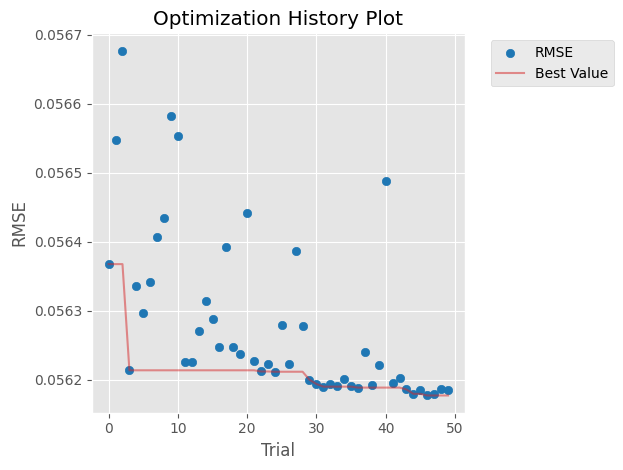

In [37]:
import matplotlib.pyplot as plt

# После optimize(...)
# График истории оптимизации
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

# Или, если хотите использование matplotlib (альтернативный вариант)
ax = optuna.visualization.matplotlib.plot_optimization_history(
    study,
    target_name='RMSE'
)
plt.tight_layout()
plt.show()

# Дополнительно: важность параметров
fig_imp = optuna.visualization.plot_param_importances(study)
fig_imp.show()


In [ ]:
## XGBoost for submission

In [48]:
parametrs = {'max_depth': 12,
 'n_estimators': 629,            
 'learning_rate': 0.012979250475635971,
 'subsample': 0.9707429033714928,
 'colsample_bytree': 0.9147427767339446,
 'colsample_bylevel': 0.8346988683782983,
 'reg_alpha': 0.014884815777159114,
 'reg_lambda': 2.9658416401715585e-05,
 'min_child_weight': 7,
 'gamma': 8.548894020869924e-06,
 'max_leaves': 121,
 'random_state': 42,
 'enable_categorical':True}

In [43]:
X.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,num_lanes_cat,lanes_speed_lightning_feature,speed_curature_ratio
0,urban,2,0.06,35,2,2,0,1,afternoon,0,1,1,2,2_35_2,0.001714
1,urban,4,0.99,35,2,0,1,0,evening,1,1,0,4,4_35_2,0.028286
2,rural,4,0.63,70,1,0,0,1,morning,1,0,2,4,4_70_1,0.009000
3,highway,4,0.07,35,1,2,1,1,morning,0,0,1,4,4_35_1,0.002000
4,rural,1,0.58,60,2,1,0,0,evening,1,0,1,1,1_60_2,0.009667


In [45]:
X_test.pop('id')
X_test['num_lanes_cat']=X_test['num_lanes']
X_test['num_lanes_cat']=X_test['num_lanes_cat'].astype('category')
X_test['weather'] = X_test['weather'].map({'clear': 0, 'foggy': 1, 'rainy':2})
X_test['weather'] = X_test['weather'].astype(int)
X_test['lighting']=X_test['lighting'].map({'night':0, 'dim':1, 'daylight' : 2})
X_test['lighting'] = X_test['lighting'].astype(int)
bool_cats=['road_signs_present','public_road', 'holiday', 'school_season']
X_test[bool_cats] = X_test[bool_cats] .astype(int)
X_test['lanes_speed_lightning_feature']=(
    X_test['num_lanes'].astype(str) + '_' +
    X_test['speed_limit'].astype(str)  + '_' + 
    X_test['lighting'].astype(str)
)
X_test['lanes_speed_lightning_feature'] = X_test['lanes_speed_lightning_feature'].astype('category')
X_test['speed_curature_ratio'] = X_test['curvature']/X_test['speed_limit']

In [55]:
for col in X_test.columns:
    if X_test[col].dtype == 'object':
         X_test[col] = X_test[col].astype('category')

In [56]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 15 columns):
 #   Column                         Non-Null Count   Dtype   
---  ------                         --------------   -----   
 0   road_type                      517754 non-null  category
 1   num_lanes                      517754 non-null  int64   
 2   curvature                      517754 non-null  float64 
 3   speed_limit                    517754 non-null  int64   
 4   lighting                       517754 non-null  int64   
 5   weather                        517754 non-null  int64   
 6   road_signs_present             517754 non-null  int64   
 7   public_road                    517754 non-null  int64   
 8   time_of_day                    517754 non-null  category
 9   holiday                        517754 non-null  int64   
 10  school_season                  517754 non-null  int64   
 11  num_reported_accidents         517754 non-null  int64   
 12  num_lanes_cat   

In [53]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172585 entries, 0 to 172584
Data columns (total 15 columns):
 #   Column                         Non-Null Count   Dtype   
---  ------                         --------------   -----   
 0   road_type                      172585 non-null  object  
 1   num_lanes                      172585 non-null  int64   
 2   curvature                      172585 non-null  float64 
 3   speed_limit                    172585 non-null  int64   
 4   lighting                       172585 non-null  int64   
 5   weather                        172585 non-null  int64   
 6   road_signs_present             172585 non-null  int64   
 7   public_road                    172585 non-null  int64   
 8   time_of_day                    172585 non-null  object  
 9   holiday                        172585 non-null  int64   
 10  school_season                  172585 non-null  int64   
 11  num_reported_accidents         172585 non-null  int64   
 12  num_lanes_cat   

In [57]:
XGB_model = XGBRegressor(**parametrs)
XGB_model.fit(X,y)
pred = XGB_model.predict(X_test)

In [59]:
forget = pd.read_csv('/kaggle/input/playground-series-s5e10/test.csv')


In [58]:
submission = pd.DataFrame({
    'id': forget['id'],
    'accident_risk': pred
})

# Save submission
submission.to_csv("submission.csv", index=False)

array([0.2974101 , 0.12581578, 0.17850645, ..., 0.25097188, 0.12709305,
       0.48977202], dtype=float32)